### Imports

In [1]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, pearsonr, spearmanr
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests

### Read every cohort study file

In [2]:
datasets = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../cohort_studies_full_data/' + "/*."+'csv'))]
cohorts = [file.split(".")[0] for file in sorted(os.listdir('../cohort_studies_full_data/'))]

In [3]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies = dict()
dfsss = dict()

for cohort, dataset in zip(cohorts, datasets):
    cohort_n = cohort.split("_MERGE")[0]
    cohort_studies[cohort_n] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit
    dfsss[cohort_n] = dataset

### Read harmonized mapping tables

In [112]:
# cohort_studies['PharmaCog'][cohort_studies['PharmaCog']['CSF_T-Tau'].isna()]

In [5]:
modality = [pd.read_csv(file, sep=',') for file in sorted(glob.glob('../feature_tables' + "/*."+'csv'))]
name = [file.split(".")[0] for file in sorted(os.listdir('../feature_tables'))]

In [6]:
# make a dictionary that contains all modalities as a dataframe
mappings = dict()

for moda, na in zip(modality, name):
    mappings[na.split(' - ')[1]] = moda

In [7]:
harmonized_features = pd.concat(mappings, ignore_index=True) # combine all tables

In [8]:
# exclude categorical and taboo features
harmonized_features = harmonized_features.loc[(harmonized_features['Rank']!=1) & (harmonized_features['Rank']!=2)]

### Read the feature availability files for all cohorts

In [9]:
ava_mapp = [pd.read_csv(file, sep='\t') for file in sorted(glob.glob('../feature_availability_in_cohorts' + "/*."+'tsv'))]
tablesss = [file.split(".")[0] for file in sorted(os.listdir('../feature_availability_in_cohorts'))]

In [10]:
# make a dictionary that contains all modalities as a dataframe
available_features = dict()

for modal, df in zip(tablesss, ava_mapp):
    available_features[modal] = df

In [11]:
existing_features = pd.concat(available_features, ignore_index=True) # combine all tables

In [12]:
existing_features.replace({0: np.nan}, inplace=True) # 0 indicates that the feature was not measured 

### Read the subtables of all cohorts to extract the "age" feature and add it to the complete tables 

In [13]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies = dict()
# dfsss = dict()

for cohort, dataset in zip(cohorts, datasets):
    cohort_n = cohort.split("_MERGE")[0]
    cohort_studies[cohort_n] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit
#     dfsss[cohort_n] = dataset

In [14]:
datasets_sub = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../preprocessed_datasets/' + "/*."+'csv'))]
cohorts_sub = [file.split(".")[0] for file in sorted(os.listdir('../preprocessed_datasets/'))]

In [15]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies_sub = dict()

for cohort, dataset in zip(cohorts_sub, datasets_sub):
    cohort_studies_sub[cohort] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit

In [16]:
for i in cohort_studies:
    cohort_studies[i]['Age']=cohort_studies_sub[i]['Age']

### Check the number of features that are common among cohorts

#### Exclude the cohorts that did not include at least two different diagnoses (e.g. CU and MCI). 

In [17]:
existing_features.drop(columns=['A4', 'ABVIB', 'PREVENT-AD', 'PharmaCog'], inplace=True)

In [18]:
for coh in range(10, len(existing_features.columns)):
    feat_ls = dict()
    
    for i in existing_features['Feature']:
        
        if len(existing_features.loc[existing_features['Feature']==i].dropna(axis=1).columns) > coh:
            feat_ls[i] = existing_features.loc[existing_features['Feature']==i].dropna(axis=1).columns
    
    print(f"number of cohorts {coh}: ", f"number of common feature {len(feat_ls.keys())}")

number of cohorts 10:  number of common feature 164
number of cohorts 11:  number of common feature 125
number of cohorts 12:  number of common feature 40
number of cohorts 13:  number of common feature 16
number of cohorts 14:  number of common feature 10
number of cohorts 15:  number of common feature 7
number of cohorts 16:  number of common feature 4


In [19]:
features_vs_cohorts = dict()

for coh in range(10, len(existing_features.columns)):

    for i in existing_features['Feature']:
        
        if len(existing_features.loc[existing_features['Feature']==i].dropna(axis=1).columns) > 10:
            features_vs_cohorts[i] = existing_features.loc[existing_features['Feature']==i].dropna(axis=1).columns

In [20]:
# make a list of ADNI features to investigate 
adni_feat = list()

for i in list(existing_features[['Feature', 'ADNI']].dropna()['Feature']):
    
    if i in harmonized_features['Feature'].to_list():
        adni_feat.append(harmonized_features.loc[harmonized_features['Feature']==i, 'ADNI'].values[0])

### Selecetion of cohort studies for A/T/N assignment

### Select the patient that have CSF biomarker, disregard the diagnostic status

In [21]:
available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:]

Index(['ADNI', 'AIBL', 'ARWIBO', 'DOD-ADNI', 'EDSD', 'EMIF', 'EPAD', 'JADNI',
       'NACC', 'PREVENT-AD', 'PharmaCog'],
      dtype='object')

In [22]:
atn = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=mappings['csf'].Feature.loc[0:2].to_list()+(["Total"]))
# atn = pd.DataFrame(index=cohort_studies, columns=['A', 'T', 'N'])

In [23]:
for cohort in atn.index:
    for feat in mappings['csf'][cohort].loc[0:2].dropna().to_list():
        if feat in cohort_studies[cohort].columns:
            atn.loc[cohort, mappings['csf'].loc[mappings['csf'][cohort]==feat, 'Feature']] = len(cohort_studies[cohort][feat].dropna())
            atn.loc[cohort, 'Total'] = len(cohort_studies[cohort][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [24]:
atn

,pTau in CSF,tTau in CSF,A-beta 1-42 in CSF,Total
ADNI,1209,1210,1023,1017
AIBL,57,57,57,57
ARWIBO,239,257,271,217
DOD-ADNI,113,116,117,113
EDSD,90,89,86,86
EMIF,1019,1020,1025,1014
EPAD,1717,1764,1297,1237
JADNI,197,197,197,197
NACC,509,537,572,506
PREVENT-AD,133,133,133,133


In [25]:
diag = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=cohort_studies['ADNI']['Diagnosis'].dropna().unique())

In [26]:
for cohort in diag.index:
    for dia in diag.columns:
        diag.loc[cohort, dia] = len(cohort_studies[cohort].loc[cohort_studies[cohort]['Diagnosis']==dia][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [27]:
diag = diag.drop(index=['AIBL', 'PREVENT-AD', 'PharmaCog'])

In [28]:
diag

,AD,CU,MCI
ADNI,220,266,531
ARWIBO,53,1,37
DOD-ADNI,0,100,13
EDSD,1,0,85
EMIF,197,193,521
EPAD,9,1227,0
JADNI,55,54,88
NACC,154,237,40


### Remove the empty columns from all cohorts that we are intrested in
### Remove the participant without all 3 CSF biomarkers

In [29]:
selected_cohorts = dict()

for coh in diag.index:
    selected_cohorts[coh] = cohort_studies[coh].dropna(axis=1, how='all')

In [30]:
total_feats = dict()

# existing_features.set_index('Feature', inplace=True)

for feat in existing_features.Feature:
    total_feats[feat] = existing_features.loc[existing_features.Feature==feat][selected_cohorts].dropna(axis=1).columns

In [31]:
for cohort in atn.index:
    feat = mappings['csf'][cohort].loc[0:2].dropna().to_list()
    cohort_studies[cohort] = cohort_studies[cohort].dropna(subset=feat)

### We at least need two cohorts for meta-analysis and we eliminate the features that are not shared among  two or more cohorts

In [32]:
meta_features = existing_features[diag.index.union(['Feature'])].dropna(thresh=7)

In [33]:
meta_features.set_index('Feature', inplace=True)

In [34]:
harmonized_features_sub = harmonized_features[diag.index.union(['Feature'])].copy()

In [35]:
for col in meta_features.columns:
    for feat in meta_features.index:
        if meta_features.loc[feat, col]!=1:
            harmonized_features_sub.loc[harmonized_features_sub.Feature==feat, col] = np.nan

In [36]:
diag.index.to_list()

['ADNI', 'ARWIBO', 'DOD-ADNI', 'EDSD', 'EMIF', 'EPAD', 'JADNI', 'NACC']

In [37]:
harmonized_features_sub.dropna(subset=diag.index.to_list(), thresh=7, inplace=True)

In [38]:
for col in harmonized_features_sub.columns:
    print(col + ":", len(harmonized_features_sub[col].dropna()))

ADNI: 27
ARWIBO: 27
DOD-ADNI: 27
EDSD: 27
EMIF: 8
EPAD: 27
Feature: 27
JADNI: 26
NACC: 27


In [39]:
for i in harmonized_features_sub.Feature.to_list(): print(i)

Mini-Mental State Examination (MMSE)
pTau in CSF
tTau in CSF
A-beta 1-42 in CSF
Age
Education
Left Hippocampus Volume
Right Hippocampus Volume
Left Middle Temporal Gray Matter Volume
Right Middle Temporal Gray Matter Volume
Right Superior Parietal Gray Matter Volume
Right Supramarginal Gray Matter Volume
Left Supramarginal Gray Matter Volume
Left Superior Parietal Gray Matter Volume
Right Postcentral Grey Matter Volume
Right Superior Frontal Gray Matter Volume
Right Superior Temporal Gray Matter Volume
Left Lingual Grey Gray Matter Volume
Left Postcentral Gray Matter Volume
Left Superior Frontal Gray Matter Volume
Right Lingual Grey Matter Volume
Left Posterior Cingulate Gray Matter Volume
Right Posterior Cingulate Gray Matter Volume
Cerebrospinal Fluid Volume
Left Precuneus Grey Matter Volume
Right Precuneus Grey Matter Volume
Third Ventricle Volume


### Check how many patients we have for each feature in each cohort 

### once considering the patients that have A/T/N measurements and once disregarding that

As Some features have suffix due to merging tables for certain cohorts, first investigate if all the harmonized features are in cohorts. Rename the ones that have suffix so it can be compatible to work with our harmonized names.

In [40]:
for dataset in diag.index:
    for feat in harmonized_features_sub[dataset].dropna().to_list():
        if feat in cohort_studies[dataset].columns:
            continue
        else:
            for cols in cohort_studies[dataset].columns:
                if feat in cols:
                    print(dataset, cols)

ADNI PTEDUCAT_x
ADNI PTEDUCAT_y


In [41]:
cohort_studies['ADNI'].rename(columns={'PTEDUCAT_x': 'PTEDUCAT'}, inplace=True)

In [42]:
ma_num_feat = pd.DataFrame(index=harmonized_features_sub.Feature, columns=diag.index)
ma_num_feat_atn = pd.DataFrame(index=harmonized_features_sub.Feature, columns=diag.index)

ma_num_feat_cu = pd.DataFrame(index=harmonized_features_sub.Feature, columns=diag.index)
ma_num_feat_mci = pd.DataFrame(index=harmonized_features_sub.Feature, columns=diag.index)
ma_num_feat_ad = pd.DataFrame(index=harmonized_features_sub.Feature, columns=diag.index)

ma_num_feat_atn_cu = pd.DataFrame(index=harmonized_features_sub.Feature, columns=diag.index)
ma_num_feat_atn_mci = pd.DataFrame(index=harmonized_features_sub.Feature, columns=diag.index)
ma_num_feat_atn_ad = pd.DataFrame(index=harmonized_features_sub.Feature, columns=diag.index)

In [43]:
for c in ma_num_feat.columns:
    
    for i in harmonized_features_sub[c].dropna().to_list():
        cu = len(cohort_studies[c].loc[cohort_studies[c].Diagnosis=='CU', i].dropna())
        mci = len(cohort_studies[c].loc[cohort_studies[c].Diagnosis=='MCI', i].dropna())
        ad = len(cohort_studies[c].loc[cohort_studies[c].Diagnosis=='AD', i].dropna())
        ma_num_feat_cu.loc[harmonized_features_sub.loc[harmonized_features_sub[c]==i, 'Feature'].item(), c] = cu
        ma_num_feat_mci.loc[harmonized_features_sub.loc[harmonized_features_sub[c]==i, 'Feature'].item(), c] = mci
        ma_num_feat_ad.loc[harmonized_features_sub.loc[harmonized_features_sub[c]==i, 'Feature'].item(), c] = ad
        ma_num_feat.loc[harmonized_features_sub.loc[harmonized_features_sub[c]==i, 'Feature'].item(), c] = f'CU: {cu}' +  ', ' + f'MCI: {mci}' + ', ' + f'AD: {ad}'

In [44]:
for c in ma_num_feat.columns:
    
    for i in harmonized_features_sub[c].dropna().to_list():
        df = cohort_studies[c].loc[cohort_studies[c][mappings['csf'].iloc[:3][c].to_list()].dropna(how='all').index]
        cu = len(df.loc[df.Diagnosis=='CU', i].dropna())
        mci = len(df.loc[df.Diagnosis=='MCI', i].dropna())
        ad = len(df.loc[df.Diagnosis=='AD', i].dropna())
        ma_num_feat_atn_cu.loc[harmonized_features_sub.loc[harmonized_features_sub[c]==i, 'Feature'].item(), c] = cu
        ma_num_feat_atn_mci.loc[harmonized_features_sub.loc[harmonized_features_sub[c]==i, 'Feature'].item(), c] = mci
        ma_num_feat_atn_ad.loc[harmonized_features_sub.loc[harmonized_features_sub[c]==i, 'Feature'].item(), c] = ad
        ma_num_feat_atn.loc[harmonized_features_sub.loc[harmonized_features_sub[c]==i, 'Feature'].item(), c] = f'CU: {cu}' +  ', ' + f'MCI: {mci}' + ', ' + f'AD: {ad}'

In [45]:
ma_num_feat_cu.reset_index(inplace=True)
ma_num_feat_mci.reset_index(inplace=True)
ma_num_feat_ad.reset_index(inplace=True)

ma_num_feat_atn_cu.reset_index(inplace=True)
ma_num_feat_atn_mci.reset_index(inplace=True)
ma_num_feat_atn_ad.reset_index(inplace=True)

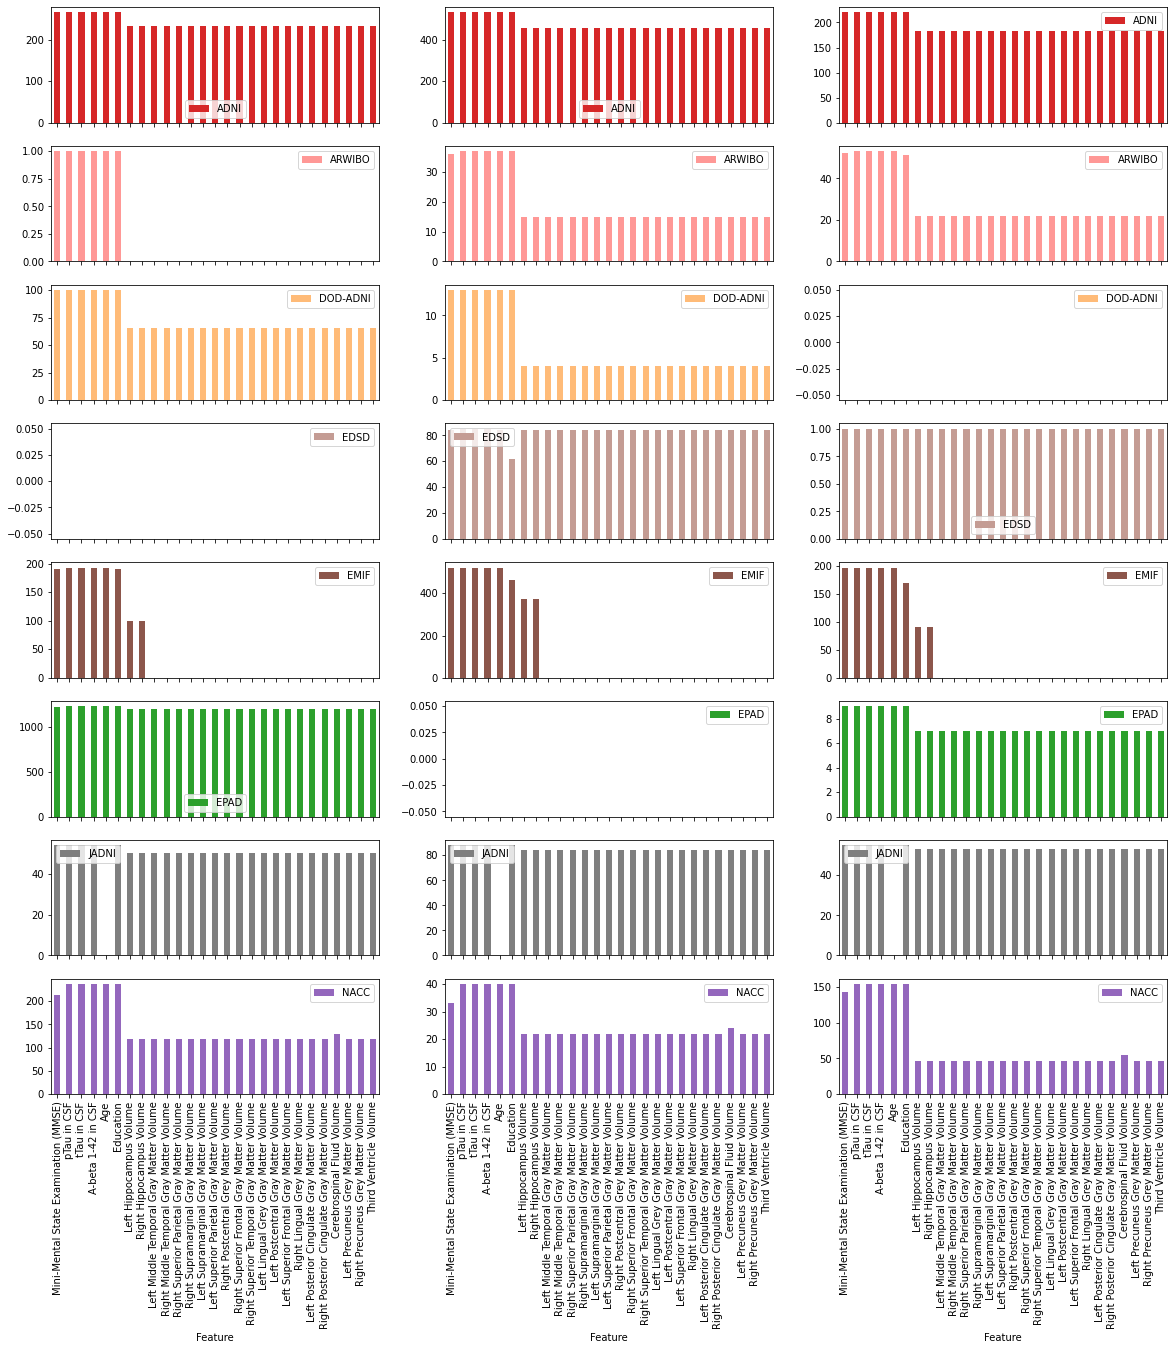

In [46]:
fig, axes = plt.subplots(8, 3, sharex=True, figsize=(20, 20))

i=0
colors = {'ADNI': '#d62728', 'NACC': '#9467bd', 'EMIF': '#8c564b', 'JADNI': '#7f7f7f', 'DOD-ADNI': '#ffbb78', 
          'ARWIBO': '#ff9896', 'EDSD': '#c49c94', 'EPAD': '#2ca02c'}
for x in ma_num_feat_cu.columns[1:]:

    ma_num_feat_cu.plot.bar(x='Feature', y=x, ax=axes[i, 0], color=colors[x])

    ma_num_feat_mci.plot.bar(x='Feature', y=x, ax=axes[i, 1], color=colors[x])

    ma_num_feat_ad.plot.bar(x='Feature', y=x, ax=axes[i, 2], color=colors[x])
    i+=1
    
plt.savefig("meta_ana_feat.png", dpi=300)

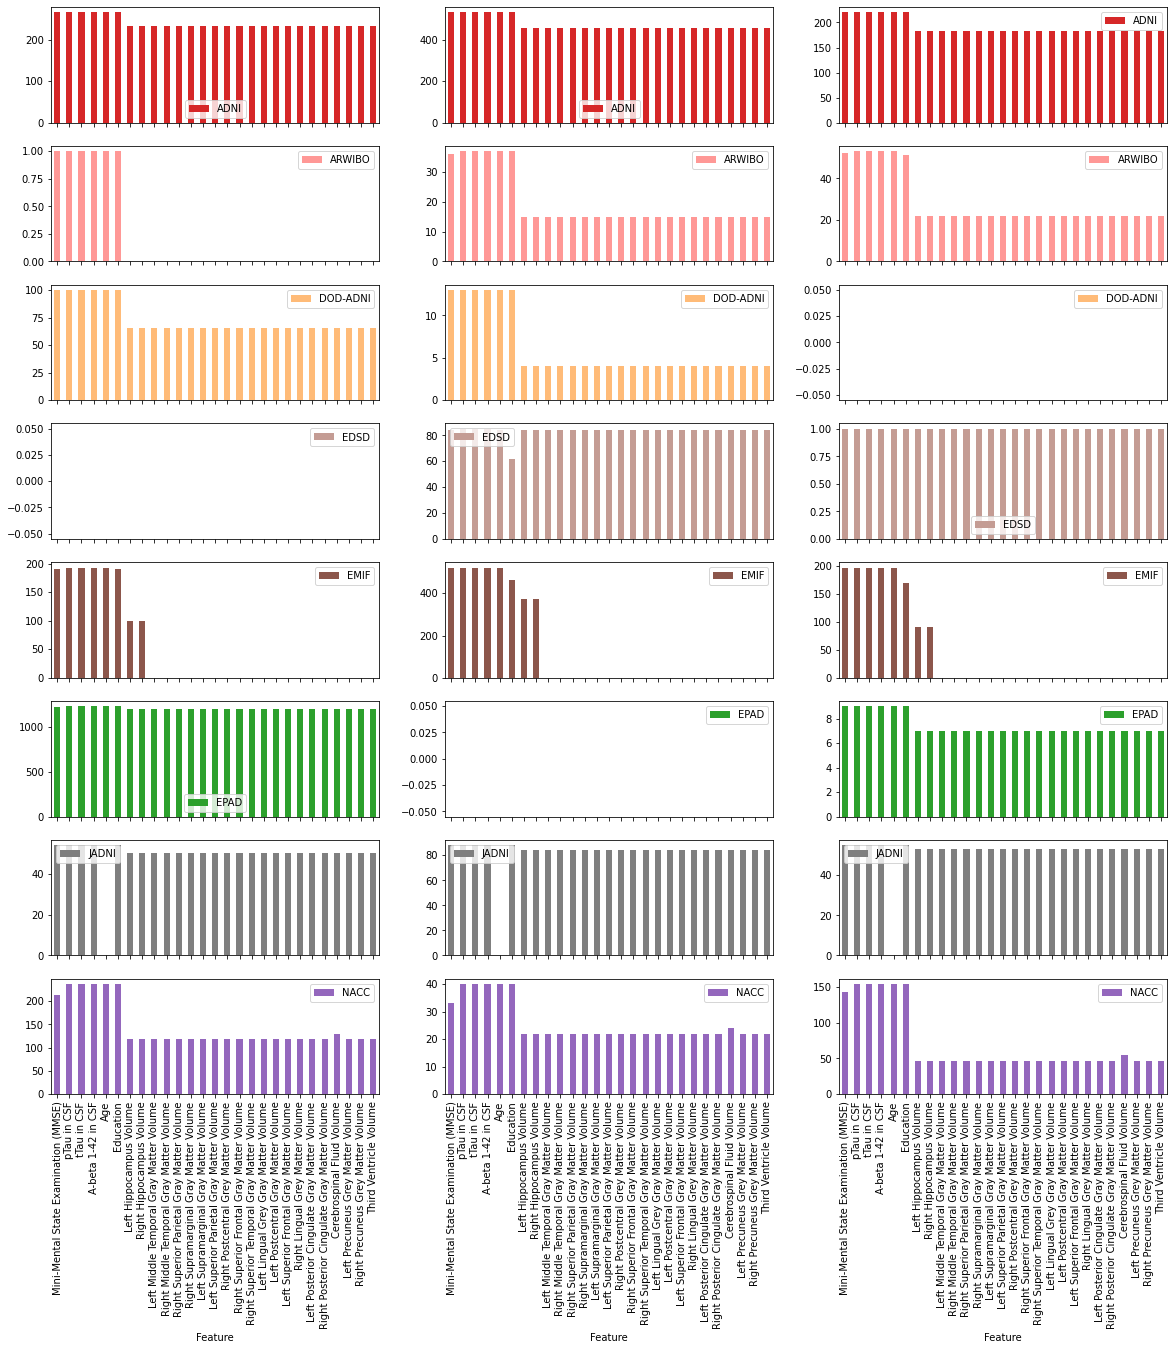

In [47]:
fig, axes = plt.subplots(8, 3, sharex=True, figsize=(20, 20))

i=0
colors = {'ADNI': '#d62728', 'NACC': '#9467bd', 'EMIF': '#8c564b', 'JADNI': '#7f7f7f', 'DOD-ADNI': '#ffbb78', 
          'ARWIBO': '#ff9896', 'EDSD': '#c49c94', 'EPAD': '#2ca02c'}
for x in ma_num_feat_atn_cu.columns[1:]:

    ma_num_feat_atn_cu.plot.bar(x='Feature', y=x, ax=axes[i, 0], color=colors[x])

    ma_num_feat_atn_mci.plot.bar(x='Feature', y=x, ax=axes[i, 1], color=colors[x])

    ma_num_feat_atn_ad.plot.bar(x='Feature', y=x, ax=axes[i, 2], color=colors[x])
    i+=1
    
plt.savefig("meta_ana_feat_atn.png", dpi=300)

# Plot the CSF biomarkers in different cohorts

In [48]:
# def plot_csf(cohort):
    
#     csf = mappings['csf'].iloc[:3][cohort].to_list()
#     for bioma in csf:
#         sns.displot(cohort_studies[cohort][bioma].dropna())

In [49]:
# plot_csf('ADNI')

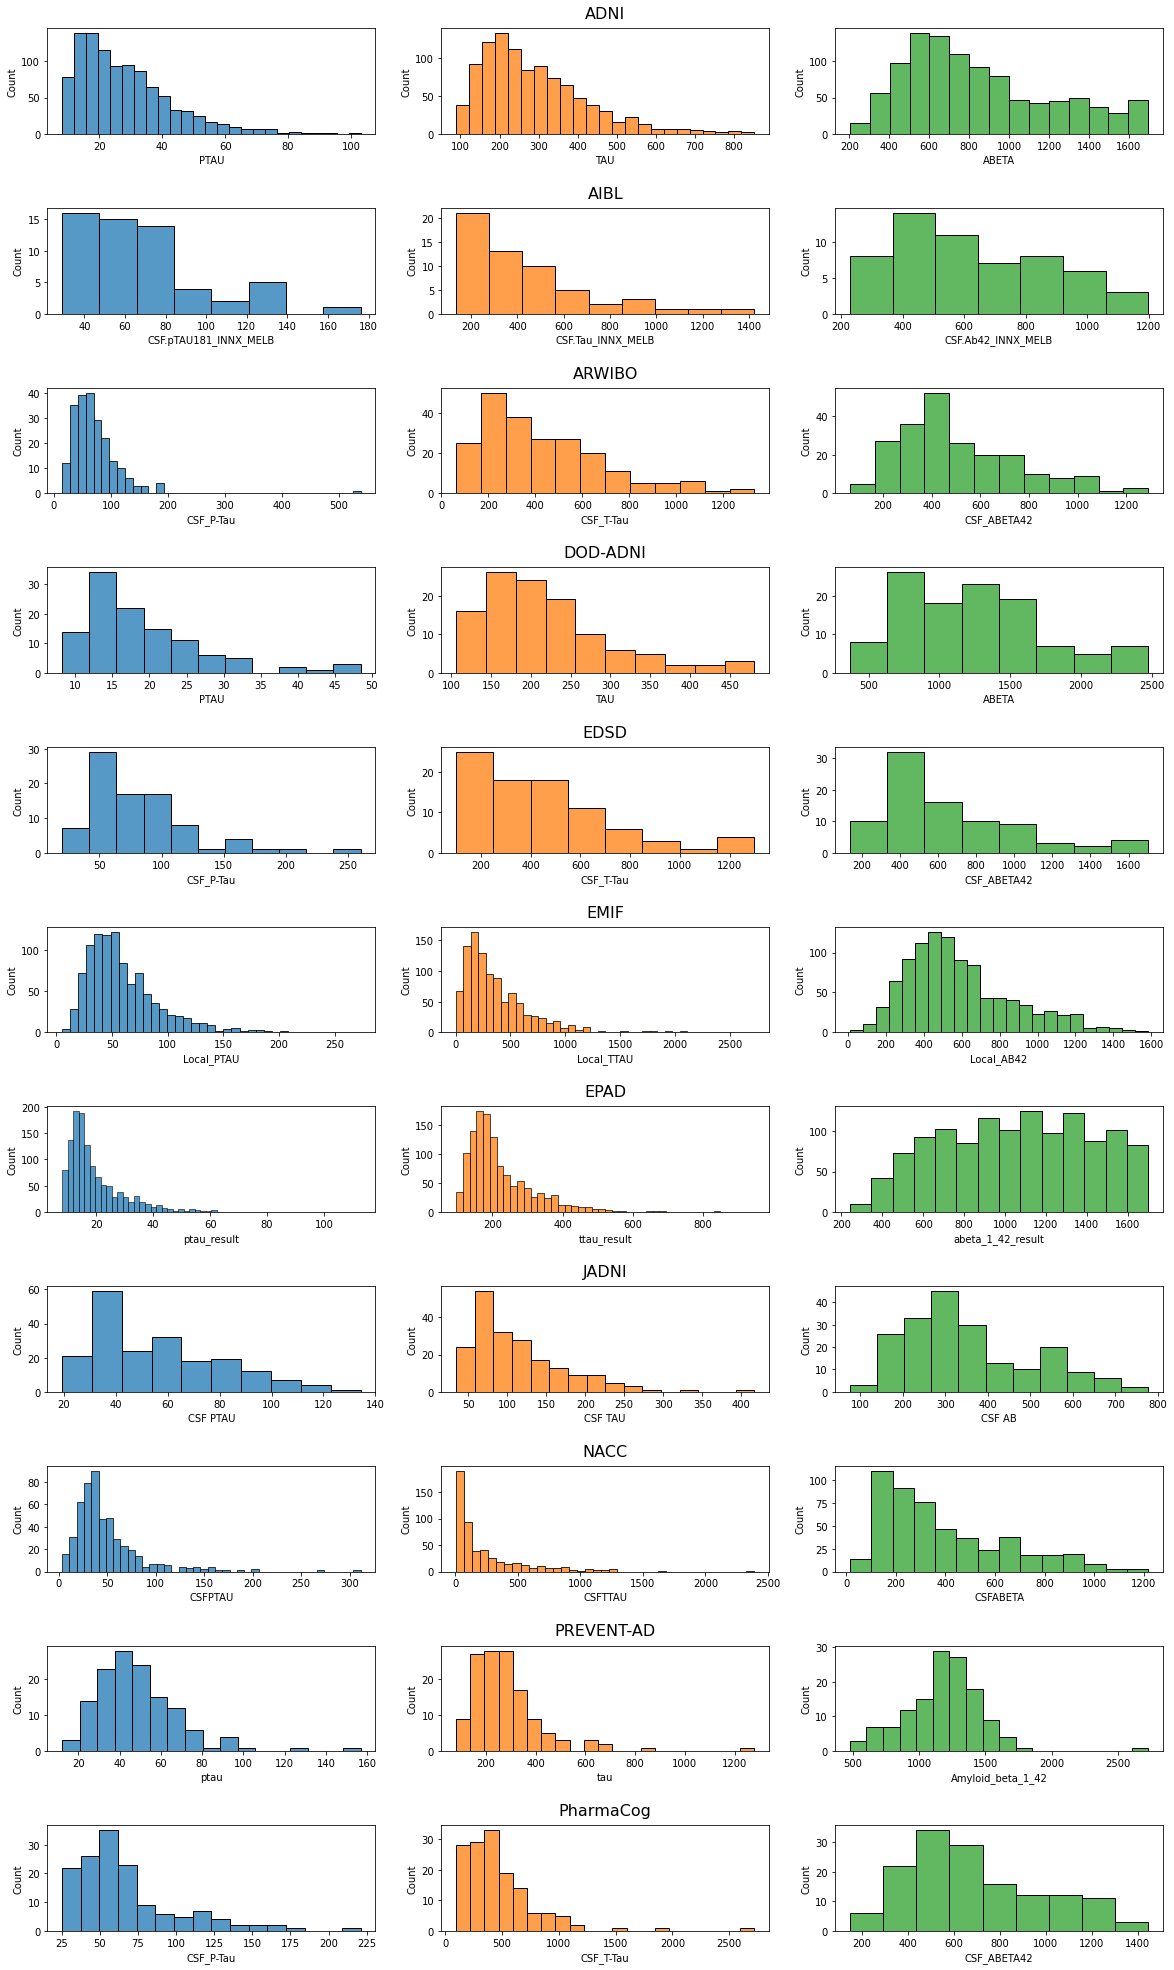

In [50]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in atn.index:
    csf = mappings['csf'].iloc[:3][ind].to_list()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma, colo in zip(csf, colors):
#         print(bioma, csf.index(bioma))
        sns.histplot(cohort_studies[ind][bioma].dropna(), ax=axes[i, csf.index(bioma)], color=colo)
#         axes[i, csf.index(bioma)].set_title(bioma.upper())
        axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
    i+=1
    
plt.savefig("csf_biomarkers.png", dpi=300)

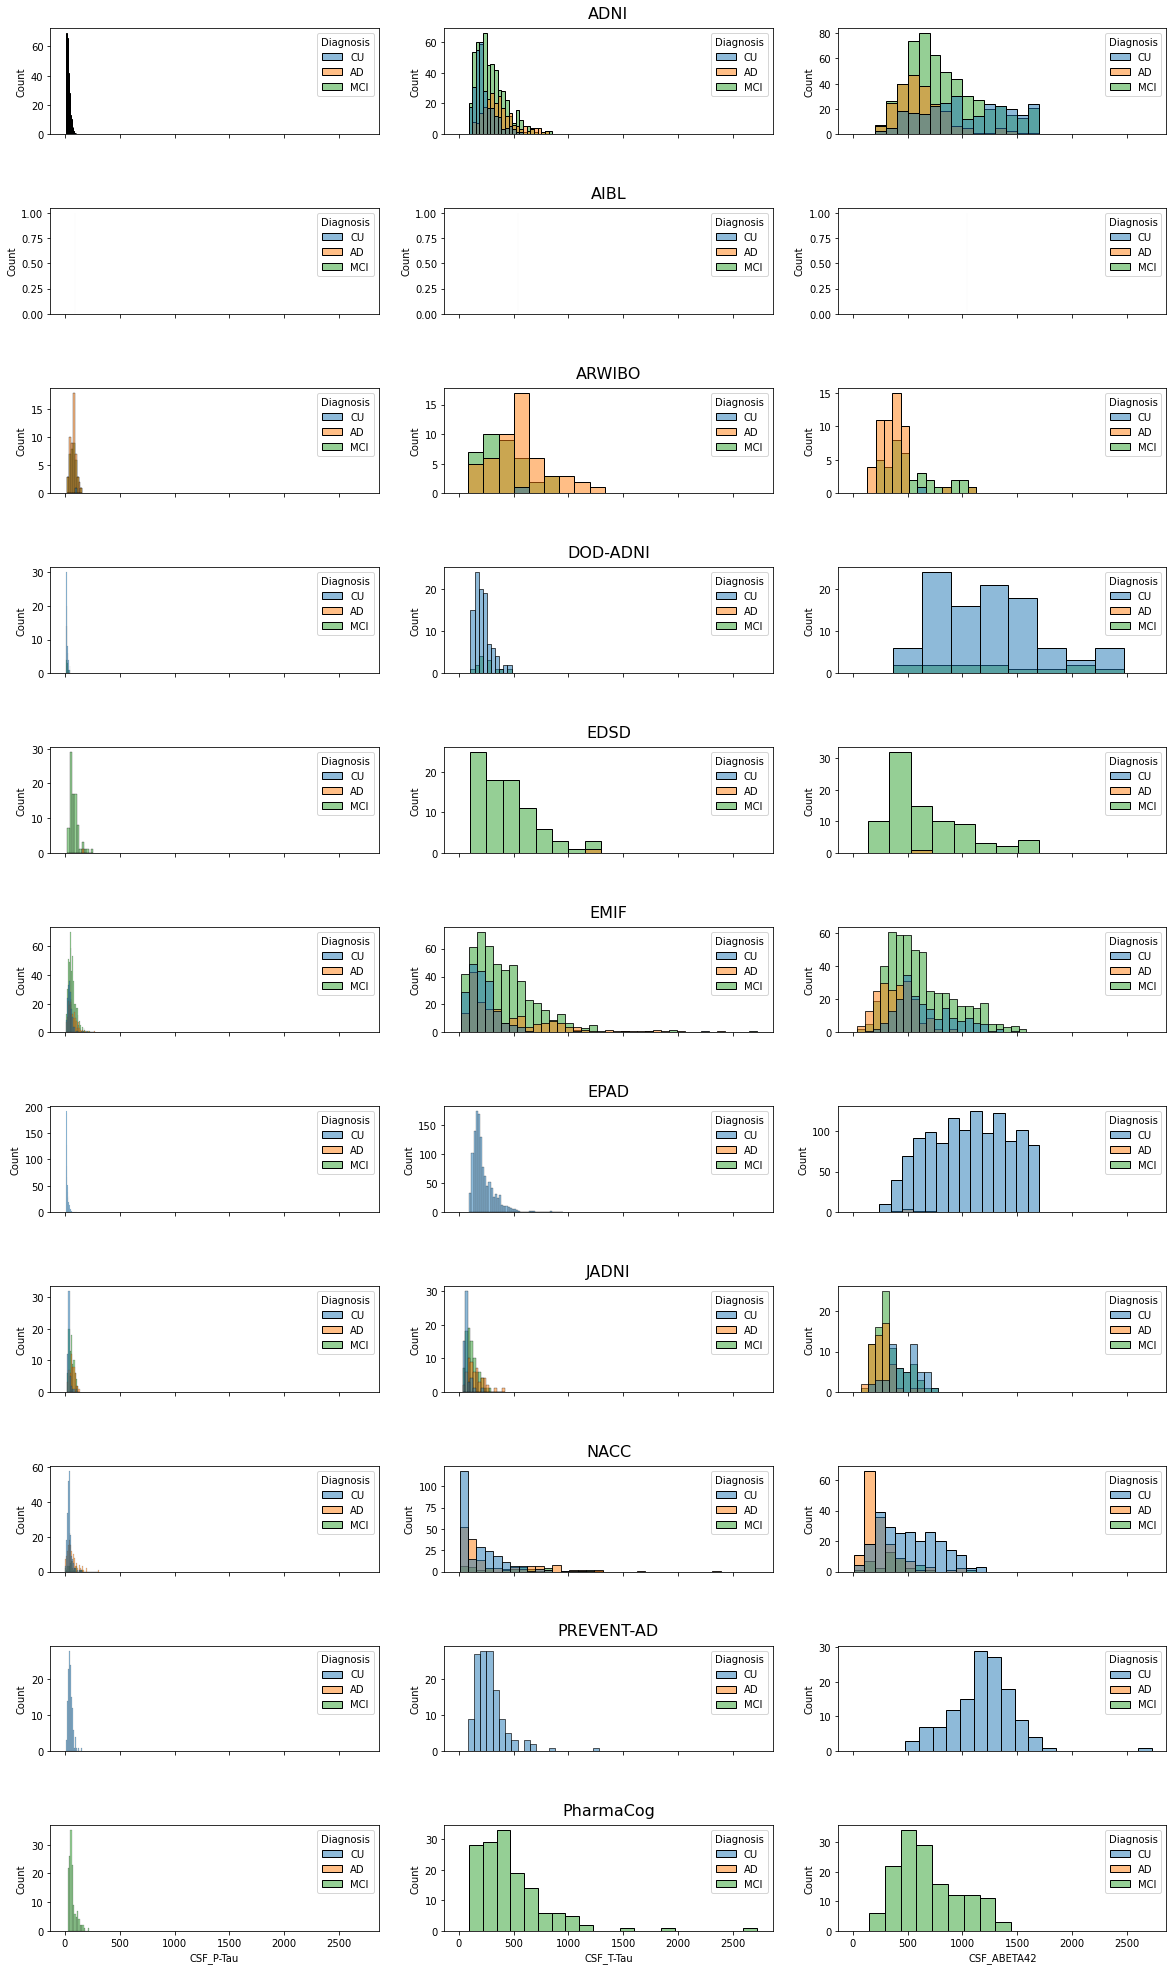

In [51]:
fig, axes = plt.subplots(11, 3, sharex=True, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in atn.index:
    csf = mappings['csf'].iloc[:3][ind].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        
    for bioma, colo in zip(csf, colors):
        sns.histplot(x=cohort_studies[ind].loc[cohort_studies[ind]['Diagnosis'].dropna().index][bioma].dropna(), ax=axes[i, csf.index(bioma)], hue=cohort_studies[ind]['Diagnosis'].dropna(), hue_order=['CU', 'AD', 'MCI'])
        axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
    i+=1
    
plt.savefig("csf_biomarkers_diag.png", dpi=300)

In [111]:
# cohort_studies['ADNI'].loc[cohort_studies["ADNI"]['Diagnosis'].dropna().index]['PTAU'].dropna()

In [53]:
# sns.displot(cohort_studies['ADNI'][mappings['csf'].iloc[:3]["ADNI"].to_list()].dropna())
# print(sns.color_palette().as_hex())

In [54]:
# fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
# fig.subplots_adjust(hspace=0.7)
# i=0

# for ind in atn.index:
#     csf = mappings['csf'].iloc[:3][ind].to_list()
    
#     for bioma, colo in zip(csf, colors):
#         qqplot(cohort_studies[ind][bioma].dropna(), ax=axes[i, csf.index(bioma)], line='s')
#         axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
#     i+=1
    
# plt.savefig("csf_biomarkers.png", dpi=300)

In [110]:
# cohort_studies['NACC'].loc[cohort_studies['NACC']['AMYLCSF']==0][['CSFABETA', 'AMYLCSF']].dropna()

In [56]:
cohort_studies['NACC']['CSFABETA'].describe()

count     506.000000
mean      389.935099
std       254.494142
min        14.500000
25%       191.907500
50%       310.220000
75%       544.657500
max      1218.000000
Name: CSFABETA, dtype: float64

### Test whether the data was drawn from a normal distribution

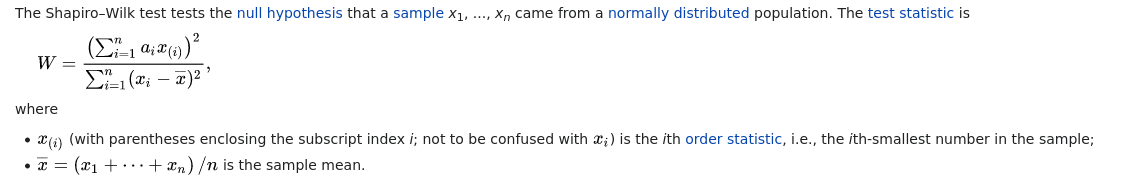

In [57]:
shapiro_result_pvalue = pd.DataFrame(index=atn.index, columns=atn.columns[:-1])

In [58]:
for ind in atn.index:
    csf = mappings['csf'].iloc[:3][ind].to_list()
    
    for bioma in csf:
        stat, p = shapiro(cohort_studies[ind][bioma].dropna())
#         print(f"{ind} :", stat, p)
        shapiro_result_pvalue.loc[ind, mappings['csf'].loc[mappings['csf'][ind]==bioma, 'Feature'].item()] = p
        if p > 0.05:
            print(ind, bioma)

We reject the null hypothesis, therefore samples are not normally distributed (i.e., data is not drawn from a Gaussian distribution).

In [59]:
shapiro_result_pvalue

,pTau in CSF,tTau in CSF,A-beta 1-42 in CSF
ADNI,0.0,0.0,0.0
AIBL,0.000071,0.000004,0.00792
ARWIBO,0.0,0.0,0.0
DOD-ADNI,0.0,0.000001,0.00172
EDSD,0.000001,0.000005,0.000003
EMIF,0.0,0.0,0.0
EPAD,0.0,0.0,0.0
JADNI,0.0,0.0,0.000001
NACC,0.0,0.0,0.0
PREVENT-AD,0.0,0.0,0.000016


In [60]:
for ind in atn.index:
    csf = mappings['csf'].iloc[:3][ind].to_list()
    
    for diag in list(cohort_studies[ind]['Diagnosis'].dropna().unique()):
        
        for bioma in csf:
            
            if len(cohort_studies[ind].loc[cohort_studies[ind]['Diagnosis']==diag][bioma].dropna())>3:
                stat, p = shapiro(cohort_studies[ind].loc[cohort_studies[ind]['Diagnosis']==diag][bioma].dropna())
        #         print(f"{ind} :", stat, p)
        #         shapiro_result_pvalue.loc[ind, mappings['csf'].loc[mappings['csf'][ind]==bioma, 'Feature'].item()] = p
                if p > 0.05:
                    print(ind, bioma, diag)

ARWIBO CSF_P-Tau MCI
ARWIBO CSF_T-Tau MCI
ARWIBO CSF_P-Tau AD
ARWIBO CSF_T-Tau AD
DOD-ADNI PTAU MCI
DOD-ADNI TAU MCI
DOD-ADNI ABETA MCI
EPAD ptau_result AD
EPAD ttau_result AD
EPAD abeta_1_42_result AD
JADNI CSF AB CU
JADNI CSF PTAU AD


### Estimating the cutpoints based on 10% percentile and once with 5% percentile

### Using arbitrary percentile and computing the youden index to select the best cutoff values

In [61]:
cutoff_ten = pd.DataFrame(index=atn.index, columns=atn.columns[:-1])

In [62]:
for coh in atn.index:
    csf = mappings['csf'].iloc[:3][coh].to_list()
    
    for bio in csf:
        
        if bio=="A-beta 1-42 in CSF":

            if len(cohort_studies[coh].loc[cohort_studies[coh]['Diagnosis']=='CU', bio].dropna())>10:
                cut_10 = np.percentile(cohort_studies[coh].loc[cohort_studies[coh]['Diagnosis']=='CU', bio].dropna(), q=10)
                cutoff_ten.loc[coh, mappings['csf'].loc[mappings['csf'][coh]==bio, 'Feature'].item()] = cut_10
                
        else:

            if len(cohort_studies[coh].loc[cohort_studies[coh]['Diagnosis']=='CU', bio].dropna())>10:
                cut_10 = np.percentile(cohort_studies[coh].loc[cohort_studies[coh]['Diagnosis']=='CU', bio].dropna(), q=90)
                cutoff_ten.loc[coh, mappings['csf'].loc[mappings['csf'][coh]==bio, 'Feature'].item()] = cut_10

In [63]:
cutoff_ten.dropna()

,pTau in CSF,tTau in CSF,A-beta 1-42 in CSF
ADNI,34.245,355.85,1564.5
DOD-ADNI,29.41,316.2,1860.5
EMIF,70.416,380.0,1065.308
EPAD,34.278,357.3,1556.4
JADNI,48.336,105.577,651.156
NACC,59.116,441.8,907.0
PREVENT-AD,72.055,440.41,1490.896


### Correlation between ptau and ttau (Pearson's Correlation Coefficient)

In [64]:
pearson_result = pd.DataFrame(index=atn.index, columns=['pearson_correlation_coefficient', 'P_value'])

for ind in atn.index:
    ptau = mappings['csf'].iloc[:1][ind].item()
    ttau = mappings['csf'].iloc[1:2][ind].item()

    r, p = pearsonr(cohort_studies[ind][ptau], cohort_studies[ind][ttau])
    pearson_result.loc[ind, 'P_value'] = p
    pearson_result.loc[ind, 'pearson_correlation_coefficient'] = r

In [65]:
pearson_result

,pearson_correlation_coefficient,P_value
ADNI,0.984964,0.0
AIBL,0.94735,0.0
ARWIBO,0.555649,0.0
DOD-ADNI,0.977058,0.0
EDSD,0.701509,0.0
EMIF,0.882485,0.0
EPAD,0.980612,0.0
JADNI,0.862834,0.0
NACC,0.64857,0.0
PREVENT-AD,0.958377,0.0


In [66]:
# plot the csf !

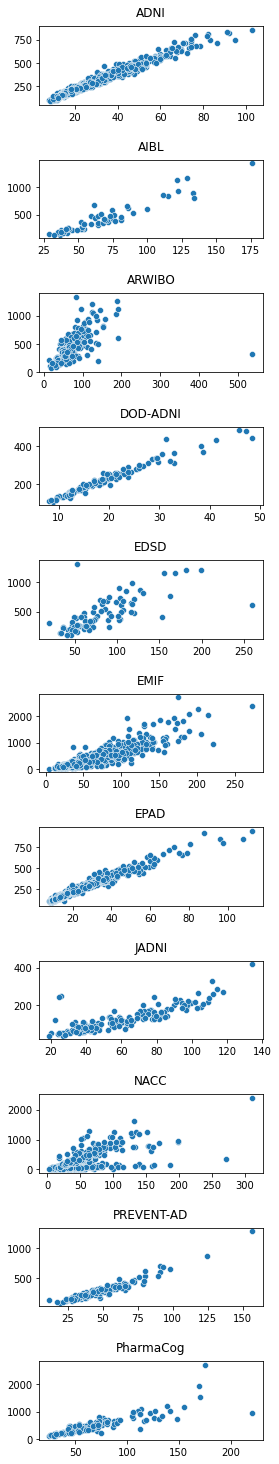

In [67]:
fig, axes = plt.subplots(11, 1, sharex=False, figsize=(4, 26))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in atn.index:
    sns.scatterplot(x=cohort_studies[ind][mappings['csf'].iloc[:1][ind].item()].to_list(), y=cohort_studies[ind][mappings['csf'].iloc[1:2][ind].item()].to_list(), ax=axes[i])
    axes[i].set_title(ind, fontsize=12, pad=10)
    
    i+=1
    
# plt.savefig("ttau_vs_ptau.png", dpi=300)

### check if each of the CSF biomarkers are correlated with age

In [68]:
pearson_result_age = pd.DataFrame(index=atn.index)
spearmanr_result_age = pd.DataFrame(index=atn.index)


for ind in atn.index:
    csf = mappings['csf'].iloc[:3][ind].to_list()
    df = cohort_studies[ind].dropna(subset=set(csf).union({'Age'}))
    
    for marker in csf:
        r, p = pearsonr(df[marker], df['Age'])
        pearson_result_age.loc[ind, mappings['csf'].iloc[csf.index(marker)]['Feature']] = str(round(r, 3)) + ' (' + str(round(p, 3)) + ')'
        
        rs, ps = spearmanr(df[marker], df['Age'])
        spearmanr_result_age.loc[ind, mappings['csf'].iloc[csf.index(marker)]['Feature'] + '_P'] = str(round(rs, 3)) + ' (' + str(round(ps, 3)) + ')'

In [69]:
pearson_result_age

,pTau in CSF,tTau in CSF,A-beta 1-42 in CSF
ADNI,0.058 (0.062),0.074 (0.018),-0.079 (0.011)
AIBL,0.203 (0.13),0.177 (0.187),-0.048 (0.722)
ARWIBO,0.152 (0.025),0.1 (0.142),0.018 (0.794)
DOD-ADNI,0.214 (0.023),0.213 (0.023),-0.004 (0.964)
EDSD,0.026 (0.812),-0.061 (0.579),-0.023 (0.834)
EMIF,0.154 (0.0),0.165 (0.0),-0.144 (0.0)
EPAD,0.317 (0.0),0.34 (0.0),-0.18 (0.0)
JADNI,0.164 (0.021),0.166 (0.02),-0.153 (0.032)
NACC,0.177 (0.0),0.096 (0.031),-0.175 (0.0)
PREVENT-AD,0.131 (0.134),0.177 (0.041),-0.04 (0.652)


In [70]:
spearmanr_result_age

,pTau in CSF_P,tTau in CSF_P,A-beta 1-42 in CSF_P
ADNI,0.117 (0.0),0.127 (0.0),-0.082 (0.009)
AIBL,0.276 (0.038),0.317 (0.016),-0.191 (0.155)
ARWIBO,0.201 (0.003),0.148 (0.029),0.033 (0.628)
DOD-ADNI,0.207 (0.028),0.195 (0.039),0.011 (0.911)
EDSD,0.098 (0.372),0.038 (0.731),0.025 (0.819)
EMIF,0.173 (0.0),0.187 (0.0),-0.171 (0.0)
EPAD,0.433 (0.0),0.435 (0.0),-0.187 (0.0)
JADNI,0.205 (0.004),0.259 (0.0),-0.119 (0.095)
NACC,0.159 (0.0),0.047 (0.289),-0.202 (0.0)
PREVENT-AD,0.17 (0.05),0.227 (0.009),0.021 (0.813)


In [71]:
multipletests([0.038, 0.016, 0.155], method='holm')[1]

array([0.076, 0.048, 0.155])

### Summary Stats of Demographic Features

In [72]:
for cohort in atn.index:
    cohort_studies_sub[cohort] = cohort_studies_sub[cohort].dropna(subset=['Ttau', 'Ptau', 'A-beta'])

In [73]:
def cat_stat_df(dfs, result):
    """Counting different categories, calculate the % of categorical features, store results in a df"""
    
    categorical = {'APOE4': [2.0, 1.0], 'Sex': ['Female']}
    column_cat = ['Sex', 'APOE4']

    for cohort in dfs:
        
        if dfs[cohort].empty==True:
            continue
        
        else:
            calc_dict = dict()
            df = dfs[cohort]

            for col in column_cat:
                ca = Counter(df[col].dropna())
                calc_dict[col] = ca

            cohort_df = pd.DataFrame(calc_dict).transpose()
            cohort_df = cohort_df.dropna(how='all')
            cohort_df.loc[cohort] = cohort_df.sum()
           
            for i in categorical:
                
                
                if i == 'APOE4':
                    
                    if 'APOE4' in list(cohort_df.index.astype(str)):
                        
                        if '2.0' not in list(cohort_df.columns.astype(str)) and '2' not in list(cohort_df.columns.astype(str)):
                            cohort_df[2.0] = np.nan
                        
                        result.loc[cohort, i] = round(100 * sum([val for val in cohort_df.loc[i, categorical[i]]]) / 
                                                     sum([val for val in cohort_df.loc[i].dropna()]), 1)
                    
                    else:
                        result.loc[cohort, i] = np.nan
                
                elif i == 'Sex':
                    
                    if (i in cohort_df.index) & ("Female" in cohort_df.columns):
                        result.loc[cohort, i] = round(100 * sum([val for val in cohort_df.loc[i, categorical[i]]]) 
                                                      / sum([val for val in cohort_df.loc[i].dropna()]), 1)
                    else:
                        result.loc[cohort, i] = 0
    
                    
    result.rename(columns={"Sex": "Female %", "APOE4": "APOE4 %"}, inplace=True)
              
    return result

In [74]:
def num_stat_df(dfs, result_df):
    """Calculating std and mean and storing it in the result dataframe"""
    
    column_names = ['Age', 'CDR', 'Education', 'MMSE', 'CDRSB', 'Hippocampus', 'A-beta', 'Ttau', 'Ptau']
    
    for df in dfs:
        dataset = dfs[df]
        calc_dict = dict()
        
        for col in column_names:
            
            if (col in dataset.columns) and (dataset[col].notna().any()):
                df_std = round(np.nanstd(dataset[col]), 1)
                df_mean = round(np.nanmean(dataset[col]), 1)
                dict_value = str(df_mean) + ' (' + str(df_std) + ')'
                calc_dict[col] = dict_value
                
            else:
                calc_dict[col] = np.nan
   
        for key in calc_dict:
            result_df.loc[df, key] = calc_dict[key]
        
    return result_df

In [75]:
cohort_studies_sub_subset = {key: cohort_studies_sub[key] for key in atn.index}

results = pd.DataFrame(index = atn.index, columns = [col for col in cohort_studies_sub['ADNI'].columns])
results.index.name = 'Name of Dataset'

cat_stat_df(cohort_studies_sub_subset, results)
num_stat_df(cohort_studies_sub_subset, results)

results.drop(columns=['Diagnosis', 'Visit', 'Race', 'Months'], inplace=True)
results

,Age,Female %,Education,APOE4 %,CDR,MMSE,CDRSB,Hippocampus,Ttau,Ptau,A-beta
Name of Dataset,,,,,,,,,,,
ADNI,73.5 (7.3),43.5,16.0 (2.7),52.3,0.4 (0.3),27.1 (2.7),1.8 (1.8),6756.7 (1173.0),290.0 (135.8),28.4 (15.1),848.3 (364.5)
AIBL,73.8 (6.4),45.6,12.7 (2.8),34.5,0.3 (0.4),26.4 (4.9),1.6 (2.7),2.8 (0.4),438.8 (276.1),68.5 (30.5),633.0 (241.8)
ARWIBO,70.5 (8.0),54.4,7.6 (4.0),39.5,0.7 (0.5),23.3 (4.8),NaN,6155.9 (1225.4),428.3 (255.7),71.9 (46.7),513.5 (239.2)
DOD-ADNI,68.5 (4.2),0.9,15.2 (2.3),25.7,0.1 (0.2),28.4 (1.5),0.4 (0.7),7741.6 (970.7),219.6 (80.8),19.1 (8.3),1242.6 (490.9)
EDSD,70.0 (6.9),44.2,11.8 (3.0),54.7,NaN,26.6 (2.1),NaN,6995.7 (1178.0),456.8 (276.8),82.0 (40.6),665.1 (345.9)
EMIF,67.9 (8.6),44.8,11.2 (4.1),NaN,0.4 (0.3),26.1 (3.8),NaN,6956.4 (1212.5),377.5 (327.6),60.0 (33.6),586.4 (282.6)
EPAD,66.1 (7.4),53.9,14.4 (3.7),47.4,0.2 (0.2),28.3 (2.1),0.4 (0.8),4730.3 (750.8),225.6 (107.3),20.1 (11.8),1056.4 (362.9)
JADNI,71.3 (6.8),50.8,13.4 (2.8),47.7,0.4 (0.3),26.3 (3.0),1.8 (1.7),6221.8 (1229.4),114.1 (61.2),56.0 (24.3),354.1 (146.5)
NACC,67.4 (10.0),50.2,15.7 (3.1),46.6,0.4 (0.5),26.1 (4.8),2.0 (2.6),6.4 (0.9),235.0 (288.2),48.4 (34.9),389.9 (254.2)


In [76]:
for i in cohort_studies_sub_subset:
    results.loc[i, 'patients'] = cohort_studies[i][mappings['csf'][i][:3].tolist()].dropna().shape[0]

In [77]:
results

,Age,Female %,Education,APOE4 %,CDR,MMSE,CDRSB,Hippocampus,Ttau,Ptau,A-beta,patients
Name of Dataset,,,,,,,,,,,,
ADNI,73.5 (7.3),43.5,16.0 (2.7),52.3,0.4 (0.3),27.1 (2.7),1.8 (1.8),6756.7 (1173.0),290.0 (135.8),28.4 (15.1),848.3 (364.5),1017.0
AIBL,73.8 (6.4),45.6,12.7 (2.8),34.5,0.3 (0.4),26.4 (4.9),1.6 (2.7),2.8 (0.4),438.8 (276.1),68.5 (30.5),633.0 (241.8),57.0
ARWIBO,70.5 (8.0),54.4,7.6 (4.0),39.5,0.7 (0.5),23.3 (4.8),NaN,6155.9 (1225.4),428.3 (255.7),71.9 (46.7),513.5 (239.2),217.0
DOD-ADNI,68.5 (4.2),0.9,15.2 (2.3),25.7,0.1 (0.2),28.4 (1.5),0.4 (0.7),7741.6 (970.7),219.6 (80.8),19.1 (8.3),1242.6 (490.9),113.0
EDSD,70.0 (6.9),44.2,11.8 (3.0),54.7,NaN,26.6 (2.1),NaN,6995.7 (1178.0),456.8 (276.8),82.0 (40.6),665.1 (345.9),86.0
EMIF,67.9 (8.6),44.8,11.2 (4.1),NaN,0.4 (0.3),26.1 (3.8),NaN,6956.4 (1212.5),377.5 (327.6),60.0 (33.6),586.4 (282.6),1014.0
EPAD,66.1 (7.4),53.9,14.4 (3.7),47.4,0.2 (0.2),28.3 (2.1),0.4 (0.8),4730.3 (750.8),225.6 (107.3),20.1 (11.8),1056.4 (362.9),1237.0
JADNI,71.3 (6.8),50.8,13.4 (2.8),47.7,0.4 (0.3),26.3 (3.0),1.8 (1.7),6221.8 (1229.4),114.1 (61.2),56.0 (24.3),354.1 (146.5),197.0
NACC,67.4 (10.0),50.2,15.7 (3.1),46.6,0.4 (0.5),26.1 (4.8),2.0 (2.6),6.4 (0.9),235.0 (288.2),48.4 (34.9),389.9 (254.2),506.0


In [78]:
Counter(cohort_studies['EMIF'][set(mappings['csf']['EMIF'][:3]).union(['Studyname'])]['Studyname'])

Counter({'Antwerp': 149,
         'EDAR': 203,
         'DESCRIPA': 25,
         'Amsterdam': 169,
         'Gothenburg': 89,
         'Pharmacog': 147,
         'IDIBAPS': 118,
         'ST PAU': 45,
         'GAP': 29,
         'Lausanne': 40})

In [79]:
for col in cohort_studies['EMIF'].columns:
    if "Local" in col: print(col)

Local_AB42
Local_AB42_Abnormal
Local_AB42_Cutoff
Local_PTAU
Local_PTAU_Abnormal
Local_PTAU_Cutoff
Local_TTAU
Local_TTAU_Abnormal
Local_TTAU_Cutoff


## EMIF Study-reported cutoffs

#### We excluded certain patients as the measurements were recorded twice with the same patient ID. This is due to merging multiple study together.  excluded IDs:
['38', '385', '262', '551', '374', '297', '359', '367', '394', '376', '24']

Study name: Leuven, GAP

In [80]:
# emif.loc[['38', '385', '262', '551', '374', '297', '359', '367', '394', '376', '24']]

In [81]:
emif_cutoffs = pd.DataFrame(index = set(cohort_studies['EMIF']['Studyname']).difference(['Leuven']), columns=['Local_AB42_Cutoff', 'Local_PTAU_Cutoff', 'Local_TTAU_Cutoff'])

In [82]:
for study in emif_cutoffs.index:
    
    for biom_ in emif_cutoffs.columns:
        
        if len(cohort_studies['EMIF'].loc[cohort_studies['EMIF']['Studyname']==study, biom_].dropna().unique()) == 1:
            emif_cutoffs.loc[study, biom_] = cohort_studies['EMIF'].loc[cohort_studies['EMIF']['Studyname']==study, biom_].dropna().unique()[0]
            
        else:
            emif_cutoffs.loc[study, biom_] = str(cohort_studies['EMIF'].loc[cohort_studies['EMIF']['Studyname']==study, biom_].dropna().unique()[0]) + ', ' + str(cohort_studies['EMIF'].loc[cohort_studies['EMIF']['Studyname']==study, biom_].dropna().unique()[1])

In [83]:
emif_cutoffs

,Local_AB42_Cutoff,Local_PTAU_Cutoff,Local_TTAU_Cutoff
Lausanne,<690,>55,>286
GAP,<550,>61,>350
DESCRIPA,<550,>52,>375
Amsterdam,<640,>52,>375
Pharmacog,<550,>61,>375
ST PAU,<550,>61,>350
IDIBAPS,"<500, <550",>75,>350
EDAR,<389,">35, >52",">98, >375"
Antwerp,<638.5,>56.5,>296.5
Gothenburg,<550,">80, >60",>400


In [84]:
for study in emif_cutoffs.index:
    emif_cutoffs.loc[study, 'Patients'] = int(len(cohort_studies['EMIF'].loc[cohort_studies['EMIF']['Studyname']==study, mappings['csf']['EMIF'][:3].tolist()].dropna()))

In [85]:
emif_cutoffs.replace(regex={"<": '', ">": ''}, inplace=True)

In [86]:
emif_cutoffs[["Patients", 'Local_AB42_Cutoff', 'Local_PTAU_Cutoff', 'Local_TTAU_Cutoff']]

,Patients,Local_AB42_Cutoff,Local_PTAU_Cutoff,Local_TTAU_Cutoff
Lausanne,40.0,690,55,286
GAP,29.0,550,61,350
DESCRIPA,25.0,550,52,375
Amsterdam,169.0,640,52,375
Pharmacog,147.0,550,61,375
ST PAU,45.0,550,61,350
IDIBAPS,118.0,"500, 550",75,350
EDAR,203.0,389,"35, 52","98, 375"
Antwerp,149.0,638.5,56.5,296.5
Gothenburg,89.0,550,"80, 60",400


### Testing

In [87]:
for i in cohort_studies['NACC'].columns:
    if 'CSFABMD' in i: print(i)

In [88]:
nacc = pd.read_csv("../data/NACC CSF-MRI/birkenbihl06182020csf.csv", index_col=0)

In [89]:
# nacc[['CSFABMD', 'CSFPTMD', 'CSFTTMD', 'CSFABMDX', 'CSFPTMDX', 'CSFTTMDX']]

In [90]:
Counter(nacc['CSFTTMD'].dropna())

Counter({1.0: 359, 2.0: 1164})

In [91]:
for i in cohort_studies['PharmaCog'].columns:
    if 'tau' in i: print(i)

Ptau_pos1


In [92]:
np.min(cohort_studies['PharmaCog'].loc[cohort_studies['PharmaCog']['Tau_pos1']==1]['CSF_T-Tau'])

482.57

In [93]:
np.max(cohort_studies['PharmaCog'].loc[cohort_studies['PharmaCog']['Tau_pos1']==0]['CSF_T-Tau'])

486.0

In [109]:
# cohort_studies['PharmaCog'].loc[(cohort_studies['PharmaCog']['CSF_P-Tau']<61) & (cohort_studies['PharmaCog']['Ptau_pos1']==1)]['CSF_P-Tau']

In [95]:
# cohort_studies['PharmaCog'].loc[(cohort_studies['PharmaCog']['CSF_T-Tau']>375) & (cohort_studies['PharmaCog']['Tau_pos1']==0)][['CSF_T-Tau', 'Tau_pos1']]

In [96]:
# cohort_studies['PharmaCog'].loc[(cohort_studies['PharmaCog']['CSF_T-Tau']>190) & (cohort_studies['PharmaCog']['Tau_pos1']==0)]['CSF_T-Tau']

In [97]:
np.max(cohort_studies['PharmaCog'].loc[cohort_studies['PharmaCog']['Tau_pos1']==0]['CSF_T-Tau'])

486.0

In [98]:
np.min(cohort_studies['PharmaCog'].loc[cohort_studies['PharmaCog']['Tau_pos1']==1]['CSF_T-Tau'])

482.57

In [99]:
# cohort_studies['PharmaCog'].loc[cohort_studies['PharmaCog']['Tau_pos1']==1]['CSF_T-Tau']

In [100]:
pharma = pd.read_csv("../data/Neugrid2/ng2_PHARMACOG_fulldataset/Patients/ng2_PHARMACOG_fulldataset.csv", index_col='PatientID', low_memory=False, encoding='latin-1')

In [101]:
# pharma.loc['PT-11-015', ['Tau_pos1', 'CSF_T-Tau']].dropna().head(50)

In [102]:
# cohort_studies['PharmaCog']

In [103]:
# cohort_studies['EMIF'].loc[cohort_studies['EMIF']['Studyname']=='Pharmacog'][['Local_TTAU', 'Local_TTAU_Cutoff', 'Local_TTAU_Abnormal']]

In [104]:
# cohort_studies['EMIF'].loc[(cohort_studies['EMIF']['Studyname']=='Pharmacog') & (cohort_studies['EMIF']['Local_TTAU']<375)]['Local_TTAU_Abnormal']

In [105]:
# emif.loc[['PT-02-001', 'PT-02-005', 'PT-04-003', 'PT-05-004', 'PT-11-002',
#        'PT-11-005', 'PT-11-008', 'PT-11-009', 'PT-11-015', 'PT-11-017',
#        'PT-11-026', 'PT-11-028', 'PT-31-006', 'PT-31-007', 'PT-33-007',
#        'PT-34-001', 'PT-36-004', 'PT-36-014', 'PT-36-016', 'PT-37-007',
#        'PT-37-008', 'PT-37-024']][['Local_TTAU', 'Local_TTAU_Cutoff', 'Local_TTAU_Abnormal']]

In [106]:
cohort_studies["ADNI"]['COLPROT_x'].unique()

array(['ADNI1', 'ADNIGO', 'ADNI2'], dtype=object)